In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
# Includes only continuous variables
# Comparison of multiple imputation methods
X = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

### 2. Imputation
---

* Requires running `02a_imputation.ipynb` for `mice::mice`

Methods included:
* Median imputation
* KNN imputation (K=5)
* MICE imptuation (in R)


In [4]:
from sklearn.impute import KNNImputer

# Median imputation
Xi_median = X.fillna(X.median())

# KNN Imputation
KNN_NEIGHBORS = 5

imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)

Xi_knn = pd.DataFrame(
    imputer.fit_transform(X), 
    index=X.index, 
    columns=X.columns
)

# MICE imputation
Xi_mice = pd.read_csv("data/imputed/mice_qvars_01.tsv", sep="\t").rename(
    columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

In [5]:
# Comparison of imputation to mean
Xi_comparison = pd.DataFrame(X.mean(), index=X.columns, columns=['original']).join(
    pd.DataFrame(Xi_median.mean(), index=X.columns, columns=['median_imputed'])).join(
    pd.DataFrame(Xi_knn.mean(), index=X.columns, columns=['knn_imputed'])).join(
    pd.DataFrame(Xi_mice.mean(), index=X.columns, columns=['mice_imputed'])
)

Xi_comparison

,original,median_imputed,knn_imputed,mice_imputed
Kappa-sFLC,86.104644,68.952657,81.832370,93.838822
Lambda-sFLC,204.033079,169.834586,215.293815,215.401005
kappa:lambda ratio,6.311743,4.809067,5.978537,7.099382
dFLC,249.375509,209.313451,257.719694,267.061561
Bone marrow plasma cells (%),9.810568,9.838679,9.707037,9.856391
IVSd,12.395546,12.357109,12.449880,12.336525
LVEF,58.700801,58.912877,58.287315,58.803255
WBC,7.912797,7.905170,7.904797,7.913068
Hemoglobin,12.917962,12.917721,12.920603,12.916094
MCV,91.273479,91.269028,91.258018,91.226903


In [6]:
err = Xi_comparison.T - Xi_comparison['original']
mse = err.T**2
mse.sum(0)

original              0.000000
median_imputed    52562.664546
knn_imputed       20534.118848
mice_imputed       9253.297307
dtype: float64

In [102]:
Xi_median.rename(columns=amyloid.ddict_clean).to_csv("data/imputed/median_qvars_01.tsv", sep="\t")
Xi_knn.rename(columns=amyloid.ddict_clean).to_csv("data/imputed/knn_qvars_01.tsv", sep="\t")

In [14]:
# Comparison for Numeric
qvars = np.array(Xi_mice.columns)

### 3. Load Conseus Cluster Plus
---

In [7]:
mice_01_ccp = pd.read_csv("data/clustering/mice_qvars_01/item_consensus.tsv", sep='\t')

n_clusters = 4

# Filter by n clusters
mice_01_ccp = mice_01_ccp[mice_01_ccp['k']==n_clusters]
mice_01_ccp = mice_01_ccp.loc[
    mice_01_ccp.groupby('item')['itemConsensus'].idxmax(),
    ['item','cluster','itemConsensus']
]

mice_01_ccp = mice_01_ccp.rename(columns={'item':'Code_ID'}).set_index("Code_ID")


In [8]:
mice_01_ccp.groupby('cluster').size(), mice_01_ccp.groupby('cluster').mean()

(cluster
 1    703
 2    846
 3    527
 4     13
 dtype: int64,
          itemConsensus
 cluster               
 1             0.642755
 2             0.753254
 3             0.644842
 4             0.490729)

In [10]:
_df= pd.read_csv("data/clustering/mice_qvars_01/item_consensus.tsv", sep='\t')
_df[
    (_df['item'].isin(mice_01_ccp[mice_01_ccp['cluster']==4].index)) &
    (_df['k']==4)
].groupby('cluster').mean()['itemConsensus']

cluster
1    0.349959
2    0.244521
3    0.246360
4    0.490729
Name: itemConsensus, dtype: float64

In [11]:
# Given low Consensus, will collapse cluster 4 -> 1
mice_01_ccp["cluster"] = mice_01_ccp["cluster"].replace({4:1})

In [17]:
data_df = data_df.join(mice_01_ccp)
data_df.rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR,"AL_with_ccp_03.tsv"), sep="\t")

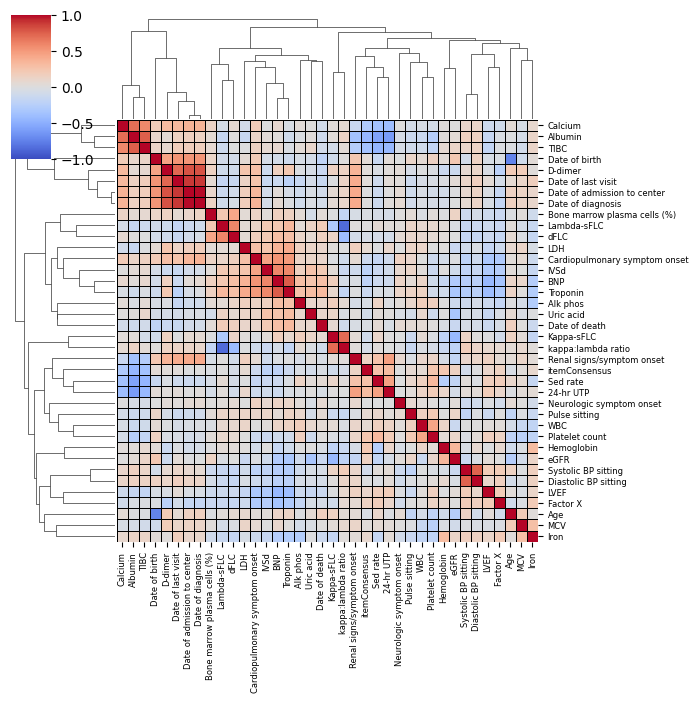

In [18]:
clustermap = sns.clustermap(
    data_df[list(qvars) + amyloid.dates + ['Age','itemConsensus']].corr("spearman"),
    xticklabels=True,
    yticklabels=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linecolor='k',
    linewidths=0.5,
    figsize=(8,8),
    #col_label_kws={'fontsize': 12}
)

_ = clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), fontsize=6)
_ = clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), fontsize=6)

In [19]:
data_df[list(qvars) + amyloid.dates + ['Age','itemConsensus']].corr("spearman")[["itemConsensus"]].sort_values(by="itemConsensus",ascending=False)

,itemConsensus
itemConsensus,1.000000
24-hr UTP,0.300719
Sed rate,0.264646
Platelet count,0.235214
Hemoglobin,0.219658
eGFR,0.144893
Factor X,0.132992
Renal signs/symptom onset,0.127027
LVEF,0.100384
Iron,0.079093


In [109]:
# Comparison for Numeric
qvars = np.array(Xi_mice.columns)

contrasts_df = utils.get_contrasts(data_df, "cluster", qvars)

100%|██████████| 4/4 [00:00<00:00, 11.20it/s]


In [110]:
contrasts_df['logq'] = -np.log10(contrasts_df['fdr_bh'])

In [125]:
contrasts_df[contrasts_df['fdr_bh'] < 0.1].groupby('cluster').size()

cluster
1.0    25
2.0    21
3.0    23
dtype: int64

In [111]:
import importlib; importlib.reload(plot)

<module 'funcs.plotting' from '/Users/sanand/Library/CloudStorage/GoogleDrive-sa20@bu.edu/My Drive/BUSM/Research/AL Amyloidosis Clustering/amyloidosis_bmc_2023/funcs/plotting.py'>

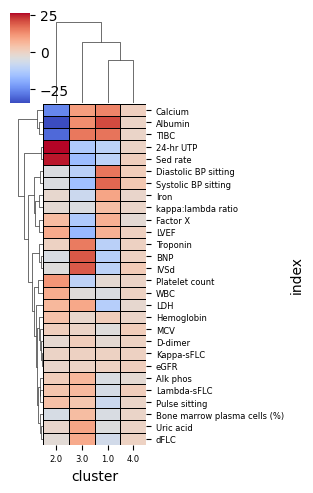

In [112]:
plot.plot_clustermap(
    contrasts_df.reset_index().pivot(values='statistic', index='index', columns='cluster'),
    figsize=(4,5),
    vmin=None, vmax=None
)

In [113]:
contrasts_df.reset_index()

,index,p_value,statistic,fdr_bh,cluster,logq
0,Albumin,8.114124e-95,20.658931,2.271955e-93,1.0,92.643600
1,Systolic BP sitting,2.448334e-69,17.600344,3.427668e-68,1.0,67.465001
2,TIBC,7.698070e-58,16.031517,7.184865e-57,1.0,56.143581
3,Diastolic BP sitting,8.733954e-57,15.879884,6.113768e-56,1.0,55.213691
4,Calcium,3.976788e-44,13.933278,2.227001e-43,1.0,42.652280
...,...,...,...,...,...,...
107,Albumin,7.690705e-01,-0.293591,8.847409e-01,4.0,0.053184
108,Kappa-sFLC,7.899472e-01,0.266379,8.847409e-01,4.0,0.053184
109,WBC,8.976261e-01,0.128661,9.666743e-01,4.0,0.014720
110,D-dimer,9.821967e-01,0.022315,9.927626e-01,4.0,0.003155


In [114]:
mice_01_ccp.join(data_df[amyloid.dates]).groupby("cluster").mean()

,itemConsensus,Date of admission to center,Date of birth,Date of diagnosis,Date of death,Date of last visit,Cardiopulmonary symptom onset,Renal signs/symptom onset,Neurologic symptom onset
cluster,,,,,,,,,
1,0.642755,2008-09-04 18:26:06.998577408,1946-07-09 22:25:46.514935936,2007-10-12 17:47:11.863442176,2009-08-21 18:00:00.000000000,2011-08-12 02:33:50.769230592,2008-04-07 20:11:19.828326144,2007-06-11 16:24:52.227979264,2005-02-09 07:08:21.265822848
2,0.753254,2007-04-07 02:17:52.340425728,1945-07-12 21:43:49.787234048,2006-10-13 23:39:34.468084992,2008-06-23 03:08:15.076400640,2009-10-27 20:47:25.917159680,2007-09-10 20:43:50.340557312,2006-07-13 13:40:59.220779136,2006-11-01 15:57:47.889908224
3,0.644842,2009-02-27 11:34:02.504743936,1947-01-04 17:01:56.129032320,2008-09-13 23:32:40.531309312,2009-02-09 05:18:00.893300224,2010-08-15 22:35:07.984790784,2008-05-05 09:13:50.769230848,2009-05-03 16:12:00.000000000,2008-02-20 19:42:30.993377536
4,0.490729,2009-05-21 22:09:13.846153728,1942-02-07 11:04:36.923076864,2008-07-17 20:18:27.692307712,2005-10-24 16:00:00.000000000,2010-06-07 18:27:41.538461440,2009-02-17 05:20:00.000000000,2011-01-18 06:51:25.714285824,2012-02-18 00:00:00.000000000


In [115]:
mice_01_ccp

,cluster,itemConsensus
Code_ID,,
6102,1,0.732434
9338,2,0.856708
9419,2,0.848466
9421,3,0.744555
9422,3,0.752229
...,...,...
2023168,2,0.668718
2023177,1,0.759726
2023181,1,0.701354


### 3. Principal Components Analysis
---

Can perform this either:
* With imputed data
* With probabalistic PCA (`ppca`)

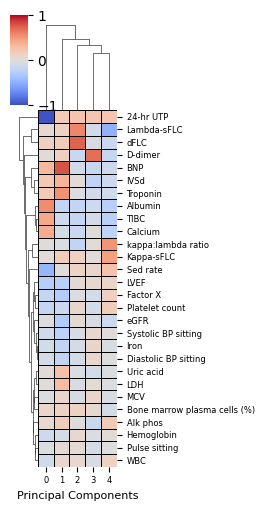

In [116]:
# Using MICE imputed
P_df, pca, pca_vars = utils.get_pcs(Xi_mice.T)

plot.plot_clustermap(
    P_df.join(Xi_mice).corr('spearman').loc[Xi_mice.columns, P_df.columns].sort_values(1),
    figsize=(3.5,5),
    xlabel='Principal Components'
)

plt.savefig("figures/mice_imputed_pca_corr.pdf", dpi=200, bbox_inches="tight")

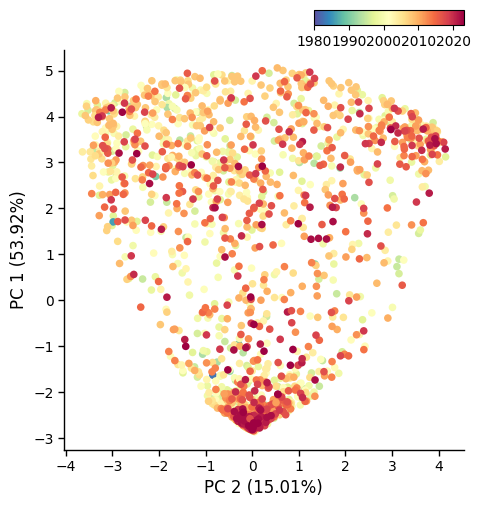

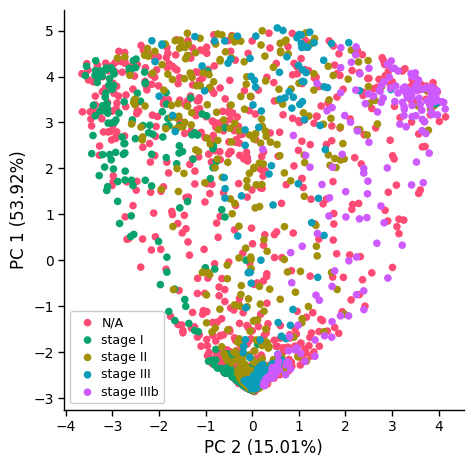

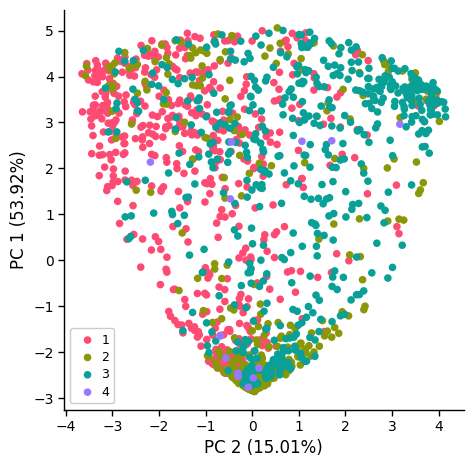

In [117]:
_ = plot.plot_pca(
    P_df,
    pca,
    c=data_df.loc[P_df.index, "Date of diagnosis"].dt.year,
    show_ax2=False,
)
plt.savefig("figures/mice_pca_diagnosis.pdf", dpi=200, bbox_inches="tight")

_ = plot.plot_pca(
    P_df,
    pca,
    cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"),
    show_ax2=False
)
plt.savefig("figures/mice_pca_bustage.pdf", dpi=200, bbox_inches="tight")

_ = plot.plot_pca(
    P_df,
    pca,
    cohort_s=mice_01_ccp.loc[P_df.index, "cluster"],
    show_ax2=False,
    order=[1,2,3]
)
plt.savefig("figures/mice_ccp_cluster.pdf", dpi=200, bbox_inches="tight")

In [118]:
# KNN Imputed
#P_df, pca, pca_vars = utils.get_pcs(Xi_knn.T)
#P_df.join(Xi_knn).corr('spearman').loc[Xi_knn.columns, P_df.columns].sort_values(1)

# _ = plot.plot_pca(
#     P_df,
#     pca,
#     c=data_df.loc[P_df.index, "Date of diagnosis"].dt.year,
#     show_ax2=False
# )

# _ = plot.plot_pca(
#     P_df,
#     pca,
#     cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"),
#     show_ax2=False
# )

In [119]:
def get_ppca(X: pd.DataFrame, normalize:bool=True):
    """Get Probablistic PCA

    Args:
        X (pd.DataFrame): _description_
        normalize (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    from ppca import PPCA
    import scipy

    if normalize:
        X = scipy.stats.zscore(X, nan_policy='omit', axis=1)
    
    ppca = PPCA()
    ppca.fit(X.values, d=100, verbose=False)

    P_df = pd.DataFrame(ppca.data, index=X.index, columns=range(ppca.data.shape[1]))
    ppca.explained_variance_ratio_ = ppca.var_exp

    return P_df, ppca

In [120]:
ppca_df, ppca = get_ppca(X)

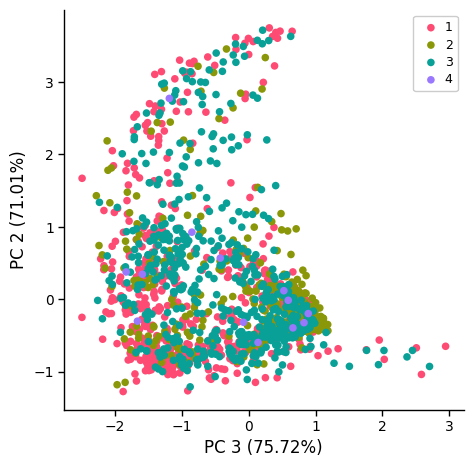

In [121]:
_ = plot.plot_pca(
    ppca_df,
    ppca,
    cohort_s=mice_01_ccp.loc[P_df.index, "cluster"],
    show_ax2=False,
    order=[2,3,4]
)

In [122]:
def plot_pca(X, ppca, x_pc=1, y_pc=2, ax=None):
    """Plot PCA."""
    P_df = pd.DataFrame(
        ppca.data, 
        index=X.index, 
        columns=["PC{}".format(x+1) for x in range(ppca.data.shape[1])]
    )

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))

    ax.scatter(P_df['PC{}'.format(x_pc)], P_df['PC{}'.format(y_pc)])

#plot_pca(X, ppca, x_pc=2, y_pc=3)